In [0]:
%pip install pyspark_dist_explore

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import *
from pyspark.sql.functions import *

In [0]:
df = spark.table("agg_match_stats_0")

In [0]:
df.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:161: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o446.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:428)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:107)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:103)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-2696346154219527> in <module>
----> 1 df.toPandas()

/databricks/spark/python/pyspark/databricks/utils/instrumentation.py in wrapper(self, *args, **kwargs)
     40         try:
     41             start_time = time.time()
---> 42             return_val = func(self, *args, **kwargs)
     43         except Exception as e:
     44             duration = (time.time() - start_time) * 1000

/databricks/spark/python/pyspark/sql/pandas/conversion.py in toPandas(self)
    115                     tmp_column_names = ['col_{}'.format(i) for i in range(len(self.columns))]
    116                     self_destruct = self.sql_ctx._conf.arrowPySparkSelfDestructEnabled()
--> 117                     batches = self.toDF(*tmp_column_names)._collect_as_arrow(
    118                         split_batches=self_destruct)
    119                     i

In [0]:
# Drop date & team_id
df = df.drop("date", "team_id")

In [0]:
df.printSchema()

root
 |-- game_size: long (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: long (nullable = true)
 |-- player_assists: long (nullable = true)
 |-- player_dbno: long (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: long (nullable = true)
 |-- player_kills: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_placement: long (nullable = true)



In [0]:
# Check missing values
for c in df.columns:
    print(c)

game_size
match_id
match_mode
party_size
player_assists
player_dbno
player_dist_ride
player_dist_walk
player_dmg
player_kills
player_name
player_survive_time
team_placement


In [0]:
# Checking number of missing values in each column
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).show()

+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+--------------+
|game_size|match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_placement|
+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+--------------+
|        0|       0|         0|         0|             0|          0|               0|               0|         0|           0|          0|                  0|             0|
+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+--------------+



There are no missing values.

Out[15]: (array([9.600000e+01, 1.638000e+03, 2.890400e+04, 2.692420e+05,
        3.854972e+06, 2.384995e+06, 7.007800e+04, 2.389130e+05,
        1.036247e+06, 3.081445e+06, 1.136000e+03, 2.736000e+03,
        7.460000e+03, 1.945500e+04, 3.046700e+04, 8.007900e+04,
        1.819190e+05, 4.027810e+05, 1.141296e+06, 1.015428e+06]),
 array([  4. ,   8.8,  13.6,  18.4,  23.2,  28. ,  32.8,  37.6,  42.4,
         47.2,  52. ,  56.8,  61.6,  66.4,  71.2,  76. ,  80.8,  85.6,
         90.4,  95.2, 100. ]),
 <BarContainer object of 20 artists>)

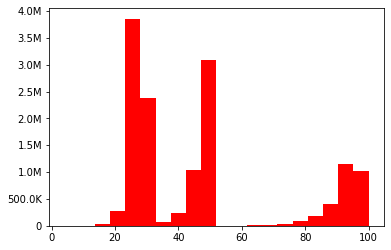

In [0]:
# Plot the distribution of columns with numerical values
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
hist(ax, df.select(df.columns[0]), bins = 20, color=['red'])

There are three modes, 'solo', 'dual', 'squad'

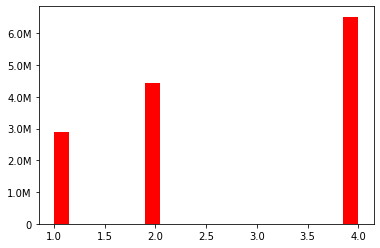

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-3046577655195590> in <module>
      1 fig, ax = plt.subplots()
      2 hist(ax, df.select(df.columns[3]), bins = 20, color=['red'])
----> 3 ax.title(df.columns[3])

TypeError: 'Text' object is not callable

In [0]:
fig, ax = plt.subplots()
hist(ax, df.select(df.columns[3]), bins = 20, color=['red'])

For the report, We will only consider games with party_size of 1.

In [0]:
# Select records with party_size equal to 1
tmp_df = df.drop("match_id", "match_mode", "player_name").filter(df.party_size == 1).drop("party_size")

In [0]:
tmp_df.show(100)

+--------------------+---------+--------------+-----------+------------------+------------------+----------+------------+-------------------+-------+--------------+
|                date|game_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_survive_time|team_id|team_placement|
+--------------------+---------+--------------+-----------+------------------+------------------+----------+------------+-------------------+-------+--------------+
|2017-12-22T18:45:...|       90|             0|          0|               0.0|        505.361755|       128|           1|             534.95| 100001|            39|
|2017-12-22T18:45:...|       90|             0|          0|               0.0|          1151.554|       215|           1|  616.5880000000001| 100008|            33|
|2017-12-22T18:45:...|       90|             0|          0|        3341.69238|1482.3076199999998|         0|           0|           1205.061| 100013|            23|
|2017-12-2

In [0]:
# Check abnormal value of team_placement. team_placement should be in the range [0, game_size].
tmp_df.filter((df.team_placement < 0) | (df.team_placement > df.game_size)).show()

+---------+--------------+-----------+----------------+----------------+----------+------------+-------------------+--------------+
|game_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_survive_time|team_placement|
+---------+--------------+-----------+----------------+----------------+----------+------------+-------------------+--------------+
+---------+--------------+-----------+----------------+----------------+----------+------------+-------------------+--------------+



Out[56]: Text(0.5, 1.0, 'player_assists')

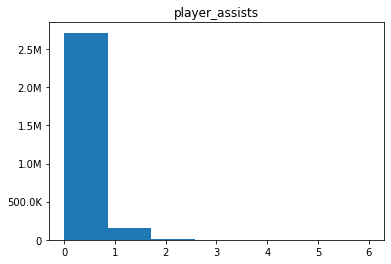

In [0]:
# Check distribution of player_assists
fig, ax = plt.subplots()
hist(ax, tmp_df.select("player_assists"), bins=7)
ax.set_title("player_assists")

Out[59]: Text(0.5, 1.0, 'player_dbno')

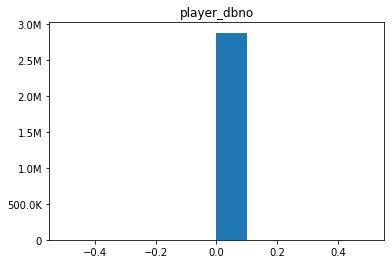

In [0]:
# Check distribution of player_assists
fig, ax = plt.subplots()
hist(ax, tmp_df.select("player_dbno"), bins=10)
ax.set_title("player_dbno")

Out[55]: Text(0.5, 1.0, 'player_kills')

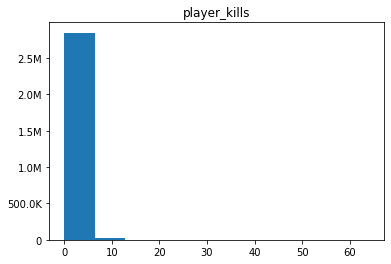

In [0]:
# Check distribution of player_assists
fig, ax = plt.subplots()
hist(ax, tmp_df.select("player_kills"), bins=10)
ax.set_title("player_kills")

In [0]:
# Boxplot of player_kills
tmp_df_pd = tmp_df.toPandas()

Out[21]: <AxesSubplot:>

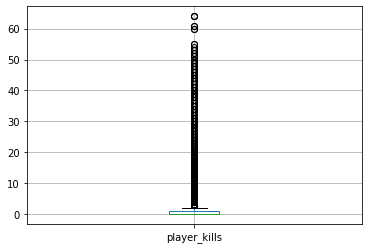

In [0]:
tmp_df_pd.boxplot(column='player_kills')

In [0]:
tmp_df_pd.corr()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-4017068688347807> in <module>
----> 1 tmp_df_pd.corr()

NameError: name 'tmp_df_pd' is not defined

In [0]:
It seems that player_kills and player_dmg are highly correlated. 

Out[45]: <AxesSubplot:xlabel='player_kills', ylabel='player_dmg'>

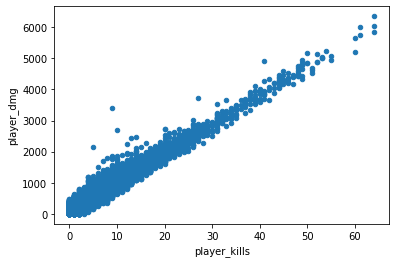

In [0]:
tmp_df_pd.plot.scatter(x = "player_kills", y = "player_dmg")

In [0]:
df.rdd

Out[49]: MapPartitionsRDD[70] at javaToPython at NativeMethodAccessorImpl.java:0

In [0]:
from pyspark.ml.feature import VectorAssembler
# Describe how columns should be collapsed into a single row-vector
vecAssembler = VectorAssembler(
    inputCols = ["game_size", "player_assists", "player_dbno", "player_dist_ride",
                 "player_dist_walk", "player_dmg", "player_kills", "player_survive_time"],
    outputCol = "features")
# Apply the transformation
vec_data = vecAssembler.transform(tmp_df)

# Preview the new Spark DataFrame
vec_data.select("game_size", "player_assists", "player_dbno", "player_dist_ride",
                 "player_dist_walk", "player_dmg", "player_kills", "player_survive_time", "features",  "team_placement").show(10)

+---------+--------------+-----------+----------------+------------------+----------+------------+-------------------+--------------------+--------------+
|game_size|player_assists|player_dbno|player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_survive_time|            features|team_placement|
+---------+--------------+-----------+----------------+------------------+----------+------------+-------------------+--------------------+--------------+
|       90|             0|          0|             0.0|        505.361755|       128|           1|             534.95|[90.0,0.0,0.0,0.0...|            39|
|       90|             0|          0|             0.0|          1151.554|       215|           1|  616.5880000000001|[90.0,0.0,0.0,0.0...|            33|
|       90|             0|          0|      3341.69238|1482.3076199999998|         0|           0|           1205.061|(8,[0,3,4,7],[90....|            23|
|       90|             0|          0|             0.0|        481.469

In [0]:
# Split data
train_data, test_data = vec_data.randomSplit([0.8, 0.2])

In [0]:
from pyspark.ml.regression import LinearRegression
# Create regression
lr = LinearRegression(maxIter = 10, regParam = 0, elasticNetParam = 0)
lr = lr.setFeaturesCol("features").setLabelCol("team_placement")
lr_model = lr.fit(train_data)

# import numpy as np
# beta_coefs = np.round(lr_model.coefficients.toArray(), 2)
# intercept = np.round(lr_model.intercept, 2)

# To predict the prices on testing set
predicted_values = lr_model.evaluate(test_data)

# Predict the model
predicted_values.predictions.select("features",  "team_placement", "prediction").show(5)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
+--------------------+--------------+------------------+
|            features|team_placement|        prediction|
+--------------------+--------------+------------------+
|(8,[0,4,7],[23.0,...|            23| 23.46866461086531|
|(8,[0,4,7],[23.0,...|            22|23.355826663290117|
|(8,[0,4,7],[23.0,...|            21|23.332055832593383|
|(8,[0,4,7],[23.0,...|            12| 22.63520396283877|
|(8,[0,4,7],[23.0,...|             7|22.527688197841435|
+--------------------+--------------+------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a prediction evaluator focused on assessing RMSE criteria
regression_eval = RegressionEvaluator(
  predictionCol = "prediction", 
  labelCol = "team_placement", 
  metricName = "rmse")

# Calculate the RMSE
rmse = regression_eval.evaluate(predicted_values.predictions)

# Display the result
print(f"RMSE is {rmse:.1f}")

RMSE is 21.3


In [0]:
lr_model.summary.pvalue

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-3046577655195604> in <module>
----> 1 lr_model.summary.pvalue

AttributeError: 'LinearRegressionTrainingSummary' object has no attribute 'pvalue'

In [0]:
from pyspark.ml.classification import LogisticRegression

In [0]:
logr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

In [0]:
lrModel = logr.fit(train_data)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
<command-4017068688347814> in <module>
----> 1 lrModel = logr.fit(train_data)

/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method(self, *args, **kwargs)
     28             call_succeeded = False
     29             try:
---> 30                 result = original_method(self, *args, **kwargs)
     31                 call_succeeded = True
     32                 return result

/databricks/spark/python/pyspark/ml/base.py in fit(self, dataset, params)
    159                 return self.copy(params)._fit(dataset)
    160             else:
--> 161                 return self._fit(dataset)
    162         else:
    163             raise TypeError("Params must be either a param map or a list/tuple of param maps, "

/databricks/spark/python/pyspark/ml/wrapper.py in _fit(self, dataset)
    333 
    334   